<a href="https://colab.research.google.com/github/yj0327/python-random-quote/blob/master/Entrenamiento_de_un_classificador_de_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial para cargar y preprocesar imagenes con TensorFlow.

In [42]:
#Importación de líbreria

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

#Descarga del conjunto de datos (imagenes)

In [43]:
#Descarga del conjunto de datos.

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [44]:
#Tamaño del conjunto de datos (imagenes).

image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


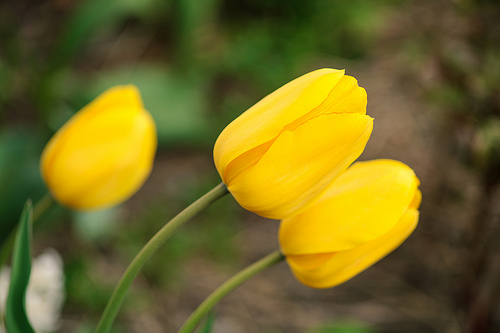

In [52]:
#Tipo de imagenes

tulips = list(data_dir.glob("tulips/*"))
PIL.Image.open(str(tulips[15]))

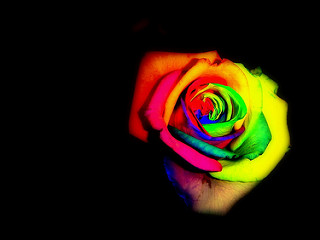

In [47]:
roses = list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[3]))

# Preprocesamiento usando Keras.preprocessing

In [ ]:
#Definición de parametros

batch_size = 32
img_height = 180
img_widht  = 180

In [64]:
#División de datos de entrenamiento y validación

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_widht),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [65]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_widht),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [66]:
#Nombre de cada atributos

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


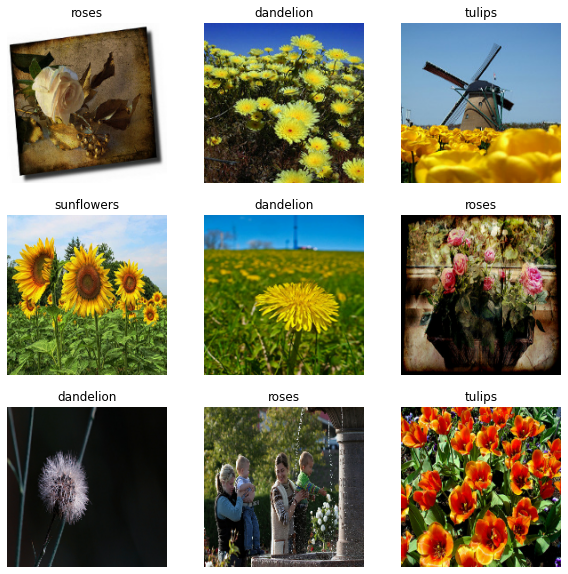

In [67]:
#Visualización de algunas imagenes del comnjuto de entrenamiento

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [68]:
#Forma(tensores) de los datos de entrenamiento

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [69]:
#Estandarización

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_bath, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image) )

0.0 255.0


In [71]:
#Configuración del conjunto de datos para el rendimiento

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [72]:
#Aumento de datos

data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                             img_widht,
                                                             3)),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1),
                                      
])

# Construcción del modelo

In [73]:

num_classes=5

model = Sequential([
                    data_augmentation,
                    layers.experimental.preprocessing.Rescaling(1/255, input_shape=(img_height, img_widht,3)),
                    layers.Conv2D(16,3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Conv2D(32,3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Conv2D(64,3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),
                    layers.Dense(num_classes)
])

In [74]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

# Entrenamiento del modelo

In [76]:
model.compile(optimizer="adam",
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=["accuracy"])

# Validación

In [77]:
epochs=5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 117s 1s/step - loss: 1.5348 - accuracy: 0.3175 - val_loss: 1.1436 - val_accuracy: 0.5395
Epoch 2/5
92/92 [==============================] - 105s 1s/step - loss: 1.0929 - accuracy: 0.5578 - val_loss: 1.0004 - val_accuracy: 0.6104
Epoch 3/5
92/92 [==============================] - 104s 1s/step - loss: 0.9804 - accuracy: 0.6198 - val_loss: 0.9427 - val_accuracy: 0.6131
Epoch 4/5
92/92 [==============================] - 103s 1s/step - loss: 0.8676 - accuracy: 0.6577 - val_loss: 0.8913 - val_accuracy: 0.6485
Epoch 5/5
92/92 [==============================] - 103s 1s/step - loss: 0.8235 - accuracy: 0.6848 - val_loss: 0.8210 - val_accuracy: 0.6730
